In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import folium
import math

In [2]:
# Foi feita a média de 10 coletas estáticas no centro de rotação do pivô com o esp32 e ficou um pouco diferente do artigo. 
# Usarei a medida do coletada, pois ao plotar no folium, é dada uma coordenada errada.
# lat_medida = -22,7134209
# long_medida = -47,6284572

# lat_artigo = -22.7132778 --- > 22°42’47.8” S
# long_artigo = -47.6291389 ---> 47°37’44.9” W

# Coordenadas para posicionar o mapa do folium no pivô
pivot_lat = -22.7134209
pivot_long = -47.6284572

# Criar o mapa centralizado na sua coordenada
map = folium.Map(location=[pivot_lat, pivot_long], zoom_start=14)

# Pontos Referência Pivô

In [3]:
# Dados do novo centro
radius_m = 10.23  # raio do círculo em metros
num_points = 720

# Constantes de conversão
meters_per_degree_lat = 111320  # metros por grau latitude
meters_per_degree_lon = meters_per_degree_lat * math.cos(math.radians(pivot_lat))  # metros por grau longitude ajustado

# Lista para armazenar os pontos do novo círculo
circle_points_pivot = []

for i in range(num_points):
    angle_deg = i * (360/num_points)
    angle_rad = math.radians(angle_deg)

    delta_lat = (radius_m * math.cos(angle_rad)) / meters_per_degree_lat
    delta_lon = (radius_m * math.sin(angle_rad)) / meters_per_degree_lon

    new_lat = pivot_lat + delta_lat
    new_lon = pivot_long + delta_lon

    circle_points_pivot.append({"latitude": new_lat, "longitude": new_lon, "angle_deg": angle_deg})

# Criar DataFrame e salvar como CSV
df_pivot_circle = pd.DataFrame(circle_points_pivot)
df_pivot_circle.to_csv("Dados/pontos_referencia_pivo.csv", index=False)

In [4]:
# Carregando as coordenadas projetadas no utilizando o centro do pivo
df_pivot = pd.read_csv('Dados/pontos_referencia_pivo.csv')
df_pivot

,latitude,longitude,angle_deg
0,-22.713329,-47.628457,0.0
1,-22.713329,-47.628456,0.5
2,-22.713329,-47.628455,1.0
3,-22.713329,-47.628455,1.5
4,-22.713329,-47.628454,2.0
...,...,...,...
715,-22.713329,-47.628462,357.5
716,-22.713329,-47.628461,358.0
717,-22.713329,-47.628460,358.5
718,-22.713329,-47.628459,359.0


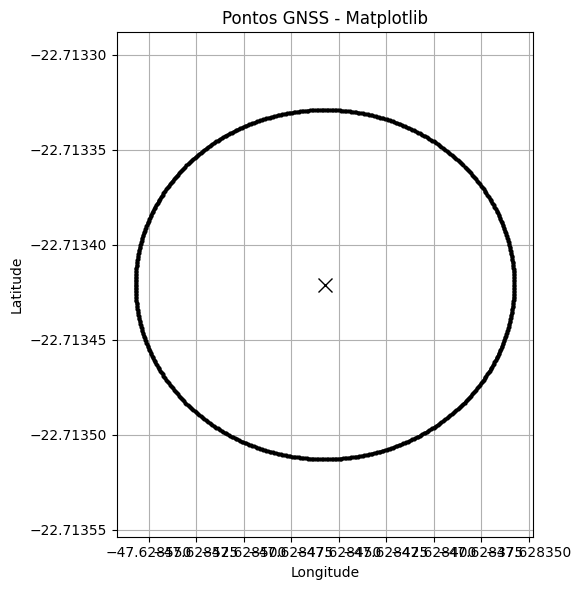

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle='-', markersize=2, color='black')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS - Matplotlib")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()


In [6]:
# Adiciona os pontos como marcadores circulares
for _, row in df_pivot.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color="black",
        fill=True,
        fill_opacity=0.7,
        popup=f'Ângulo: {row["angle_deg"]}°'
    ).add_to(map)

folium.CircleMarker(
    location=[pivot_lat, pivot_long],
    radius=2,
    color="black",
    fill=True,
    fill_opacity=0.7,
    popup=f'Ângulo: {row["angle_deg"]}°'
).add_to(map)

# Salva o mapa em HTML
map.save("mapa_gnss_pontos.html")

# Ensaios Realizados

Os ensaios estão organizados da seguinte forma:

- ❌ Volta 1: 12,5 Hz (o esp32 não coletou por conta de problemas na rede de energia, nos proximos foi usado um powerbank)   --> 23/04/25 11:28 até 12:38
- ✅ Volta 2: 12,5 Hz (todos os equipamentos coletaram)   --> 23/04/25 15:51 até 17:01
- ❌ Volta 3: 12,5 Hz (o app SW Maps não coletou)         --> 24/04/25 14:55 até 16:05
- ✅ Volta 4: 25 Hz (todos os equipamentos coletaram)     --> 25/04/25 9:20 até 10:30
- ✅ Volta 5: 25 Hz (todos os equipamentos coletaram)     --> 25/04/25 10:50 até 12:00


- ✅ Volta 6: 25 Hz (todos os equipamentos coletaram)     --> 25/04/25 12:25 até 13:35
- ✅ Volta 7: 12,5 Hz (todos os equipamentos coletaram)   --> 25/04/25 13:58 até 15:08
- ✅ Volta 8: 12,5 Hz (todos os equipamentos coletaram)   --> 25/04/25 15:50 até 17:00

12,5 Hz no inversor corresponde a 2,5 m/s
25 Hz no inversor corresponde a 5 m/s

Foram feitas coletas pontuais antes da volta 4, contudo o método utilizado para coleta foi de 1:10h de coleta e 20m de pausa para dar tempo de mudar a constelação dos satélites. A volta 2 irá compor a volta faltante para a situação de 12,5 HZ.

Os dados foram coletados a cada 5 segundos.

In [7]:
'''
Como houveram ensaios que nem todos os dispositivos conseguiram coletar, vou organizar da seguinte forma:

 - lap_1 = Volta 4
 - lap_2 = Volta 5
 - lap_3 = Volta 6
 - lap_4 = Volta 7
 - lap_5 = Volta 8
 - lap_6 = Volta 2

'''

laps = {
    "lap_1": {
        "lap_start": "2025-04-25 09:20",
        "lap_end": "2025-04-25 10:30",
    },
    "lap_2": {
        "lap_start": "2025-04-25 10:50",
        "lap_end": "2025-04-25 12:00",
    },
    "lap_3": {
        "lap_start": "2025-04-25 12:25",
        "lap_end": "2025-04-25 13:35",
    },
    "lap_4": {
        "lap_start": "2025-04-25 13:58",
        "lap_end": "2025-04-25 15:08",
    },
    "lap_5": {
        "lap_start": "2025-04-25 15:50",
        "lap_end": "2025-04-25 17:00",
    },
    "lap_6": {
        "lap_start": "2025-04-23 15:51",
        "lap_end": "2025-04-23 17:01",
    },
}

## ESP32

In [ ]:

df_esp_250_1 = pd.read_csv('Dados/esp32_volta_4.csv') # 25Hz inversor = 2,5ms - lap_1
df_esp_250_2 = pd.read_csv('Dados/esp32_volta_5.csv') # 25Hz inversor = 2,5ms - lap_2
df_esp_250_3 = pd.read_csv('Dados/esp32_volta_6.csv') # 25Hz inversor = 2,5ms - lap_3

df_esp_125_1 = pd.read_csv('Dados/esp32_volta_7.csv') # 12,5Hz inversor = 2,5ms - lap_4
df_esp_125_2 = pd.read_csv('Dados/esp32_volta_8.csv') # 12,5Hz inversor = 2,5ms - lap_5
df_esp_125_3 = pd.read_csv('Dados/esp32_volta_2.csv') # 12,5Hz inversor = 2,5ms - lap_6


laps["lap_1"]["data_esp"] = df_esp_250_1
laps["lap_2"]["data_esp"] = df_esp_250_2
laps["lap_3"]["data_esp"] = df_esp_250_3
laps["lap_4"]["data_esp"] = df_esp_125_1
laps["lap_5"]["data_esp"] = df_esp_125_2
laps["lap_6"]["data_esp"] = df_esp_125_3

laps["lap_6"]["data_esp"]


,2025-04-23 15:54:15,2025-4-23 18:54:15,-22.713407,-47.628441,543.300000,0.87,10
0,2025-04-23 15:54:17,2025-4-23 18:54:16,-22.713423,-47.628442,543.2,0.87,10
1,2025-04-23 15:54:18,2025-4-23 18:54:17,-22.713440,-47.628447,543.1,0.87,10
2,2025-04-23 15:54:19,2025-4-23 18:54:19,-22.713468,-47.628464,543.1,0.87,10
3,2025-04-23 15:54:20,2025-4-23 18:54:20,-22.713479,-47.628477,543.4,0.87,10
4,2025-04-23 15:54:21,2025-4-23 18:54:21,-22.713489,-47.628491,543.4,0.87,10
...,...,...,...,...,...,...,...
3292,2025-04-23 16:54:10,2025-4-23 19:54:10,-22.713385,-47.628626,546.8,1.18,9
3293,2025-04-23 16:54:11,2025-4-23 19:54:11,-22.713372,-47.628616,546.9,0.93,10
3294,2025-04-23 16:54:12,2025-4-23 19:54:12,-22.713360,-47.628603,547.0,0.93,10
3295,2025-04-23 16:54:13,2025-4-23 19:54:13,-22.713351,-47.628588,546.9,0.93,10


In [12]:
# Percorrendo as chaves do dicionário, estou renomeando as colunas, cortando os dados capturados fora do range de lap_start e lap_end e
# diminuindo a frequência de coleta, pois o esp32 eu configurei para coletar a cada 1 seg e selecionei dados a cada 5 seg

for lap_name, lap_data in laps.items():
    if "data_esp" in lap_data:
        dataframe = lap_data["data_esp"]

        # Renomeia as colunas
        dataframe.columns = ['timestamp_net', 'timestamp_gps', 'latitude', 'longitude', 'altitude', 'hdop', 'satélites']
        
        # Converte a coluna 'timestamp_net' para datetime
        dataframe['timestamp_net'] = pd.to_datetime(dataframe['timestamp_net'])
        
        # Usa o lap_start e lap_end da volta como timestamps
        start_time = pd.Timestamp(lap_data["lap_start"])
        end_time = pd.Timestamp(lap_data["lap_end"])
        
        # Filtra os dados dentro do intervalo de tempo da volta
        dataframe = dataframe[
            (dataframe['timestamp_net'] >= start_time) &
            (dataframe['timestamp_net'] <= end_time)
        ]
        
        # Ordena por timestamp e reseta o índice
        dataframe = dataframe.sort_values('timestamp_net').reset_index(drop=True)
        
        # Seleciona linhas com múltiplos de 5 segundos exatos a partir do start_time
        dataframe = dataframe[
            ((dataframe['timestamp_net'] - start_time).dt.total_seconds() % 5 == 0)]
        
        # Atualiza o dataframe tratado no dicionário
        laps[lap_name]["data_esp"] = dataframe


In [13]:
laps["lap_1"]["data_esp"]

,timestamp_net,timestamp_gps,latitude,longitude,altitude,hdop,satélites
0,2025-04-25 09:20:00,2025-4-25 12:20:0,-22.713417,-47.628482,547.9,1.29,9
1,2025-04-25 09:20:05,2025-4-25 12:20:5,-22.713447,-47.628639,547.4,1.29,9
2,2025-04-25 09:20:10,2025-4-25 12:20:10,-22.713302,-47.628628,547.6,1.14,10
3,2025-04-25 09:20:15,2025-4-25 12:20:15,-22.713350,-47.628475,548.7,1.14,10
4,2025-04-25 09:20:20,2025-4-25 12:20:20,-22.713468,-47.628569,547.8,1.14,10
...,...,...,...,...,...,...,...
773,2025-04-25 10:29:40,2025-4-25 13:29:40,-22.713343,-47.628670,547.7,0.95,9
774,2025-04-25 10:29:45,2025-4-25 13:29:45,-22.713341,-47.628670,547.4,0.95,9
775,2025-04-25 10:29:50,2025-4-25 13:29:50,-22.713341,-47.628670,547.4,0.95,9
776,2025-04-25 10:29:55,2025-4-25 13:29:55,-22.713342,-47.628669,547.5,0.95,9


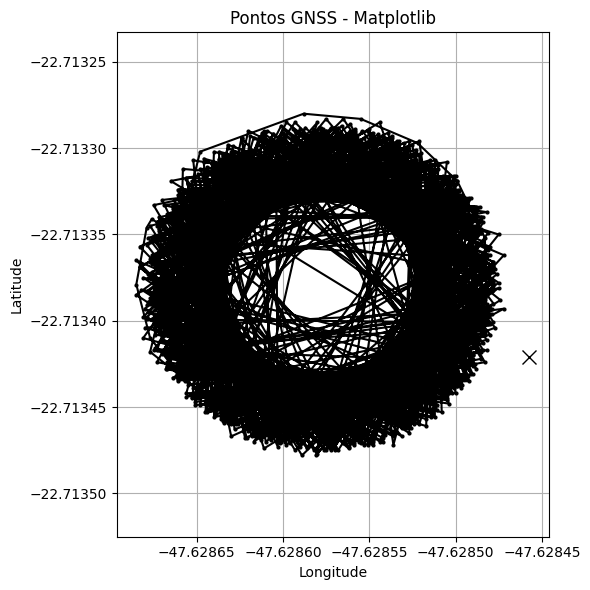

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot( laps['lap_1']["data_esp"]["longitude"], laps['lap_1']["data_esp"]["latitude"], marker='o', linestyle='-', markersize=2, color='black')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS - Matplotlib")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()


In [101]:
df = pd.read_csv('Dados/esp32_volta_2.csv')

timestamp_index = 0
latitude_index = 2
longitude_index = 3

# Adicionar os pontos ao mapa
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row[latitude_index], row[longitude_index]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Timestamp: {row[timestamp_index]}"
    ).add_to(map)

# Salva o mapa em HTML
map.save("mapa_gnss_pontos.html")

C:\Users\sn1079439\AppData\Local\Temp\ipykernel_22096\2495088894.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  location=[row[latitude_index], row[longitude_index]],
C:\Users\sn1079439\AppData\Local\Temp\ipykernel_22096\2495088894.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  popup=f"Timestamp: {row[timestamp_index]}"


Mapa salvo como 'mapa_pontos.html'


# Cálculo dos Erros

## Erro Volta 1

## Erro Volta 2

In [33]:
df_garmin_2 = pd.read_excel('Dados/garmin_volta_2.xlsx', header=None)
df_garmin_2

ValueError: Worksheet index 0 is invalid, 0 worksheets found

In [ ]:
## ESP32 Volta 2

df_esp_2 = pd.read_csv('Dados/esp32_volta_2.csv', header=None)
df_esp_2.columns = ['timestamp_net', 'timestamp_gps', 'latitude', 'longitude', 'altitude', 'hdop', 'satélites']


# Converte a coluna 'timestamp_net' para datetime
df_esp_2['timestamp_net'] = pd.to_datetime(df_esp_2['timestamp_net'])

# Define o timestamp inicial
start_time = pd.Timestamp('2025-04-23 15:54:15')

# Filtra os dados a partir do timestamp inicial
df_esp_2 = df_esp_2[df_esp_2['timestamp_net'] >= start_time]

# Ordena por timestamp e reseta o índice
df_esp_2 = df_esp_2.sort_values('timestamp_net').reset_index(drop=True)

# Seleciona linhas com múltiplos de 5 segundos exatos
df_esp_2 = df_esp_2[
    ((df_esp_2['timestamp_net'] - start_time).dt.total_seconds() % 5 == 0)
]

df_esp_2[0:20]

,timestamp_net,timestamp_gps,latitude,longitude,altitude,hdop,satélites
0,2025-04-23 15:54:15,2025-4-23 18:54:15,-22.713407,-47.628441,543.3,0.87,10
4,2025-04-23 15:54:20,2025-4-23 18:54:20,-22.713479,-47.628477,543.4,0.87,10
9,2025-04-23 15:54:25,2025-4-23 18:54:25,-22.713498,-47.628562,543.3,0.87,10
14,2025-04-23 15:54:30,2025-4-23 18:54:30,-22.713447,-47.628626,543.3,0.87,10
19,2025-04-23 15:54:35,2025-4-23 18:54:35,-22.713367,-47.628620,543.4,0.87,10
24,2025-04-23 15:54:40,2025-4-23 18:54:40,-22.713322,-47.628547,543.8,0.87,10
33,2025-04-23 15:54:50,2025-4-23 18:54:50,-22.713423,-47.628437,543.7,0.87,10
38,2025-04-23 15:54:55,2025-4-23 18:54:55,-22.713489,-47.628487,544.1,0.87,10
43,2025-04-23 15:55:00,2025-4-23 18:55:0,-22.713492,-47.628576,544.0,0.87,10
48,2025-04-23 15:55:05,2025-4-23 18:55:5,-22.713430,-47.628632,543.9,0.87,10
